In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import pickle

from datetime import datetime
from tqdm import tqdm
from plfit import plfit
from glob import glob
from collections import Counter
from utils import ReachFinder

from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 100
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

In [3]:
G = nx.read_gexf("../../state_files/PyPi Network V4.gexf")
print(G)

DiGraph with 185279 nodes and 879912 edges


In [6]:
pos = nx.spring_layout(G, seed=42, iterations= 1)

In [1]:
plt.figure(figsize=(12,8))

nx.draw_networkx_nodes(G, pos=pos, nodelist = G.nodes(), alpha=1, node_size=5)

NameError: name 'plt' is not defined

## Distribuciones de Grado

c:\Users\facuj\AppData\Local\Programs\Python\Python310\lib\site-packages\plfit\plfit.py:1012: RuntimeWarning: divide by zero encountered in log
  alpha = 1.0 + float(nn) * (sum(log(xx/(float(xmin)-0.5))))**-1
c:\Users\facuj\AppData\Local\Programs\Python\Python310\lib\site-packages\plfit\plfit.py:1012: RuntimeWarning: invalid value encountered in log
  alpha = 1.0 + float(nn) * (sum(log(xx/(float(xmin)-0.5))))**-1
c:\Users\facuj\AppData\Local\Programs\Python\Python310\lib\site-packages\plfit\plfit.py:1065: RuntimeWarning: divide by zero encountered in divide
  model_cdf = 1.0-(zz.astype('float')/float(xmin))**(1.0-alpha)
c:\Users\facuj\AppData\Local\Programs\Python\Python310\lib\site-packages\plfit\plfit.py:1065: RuntimeWarning: invalid value encountered in divide
  model_cdf = 1.0-(zz.astype('float')/float(xmin))**(1.0-alpha)


Grado Out
k_max = 29110
gamma = (1.78 ± 0.01)
k_min = 12
k_sat = 0.0096
Grado In
k_max = 453
gamma = (3.52 ± 0.05)
k_min = 27
k_sat = 0.0108
k_mean = 4.65


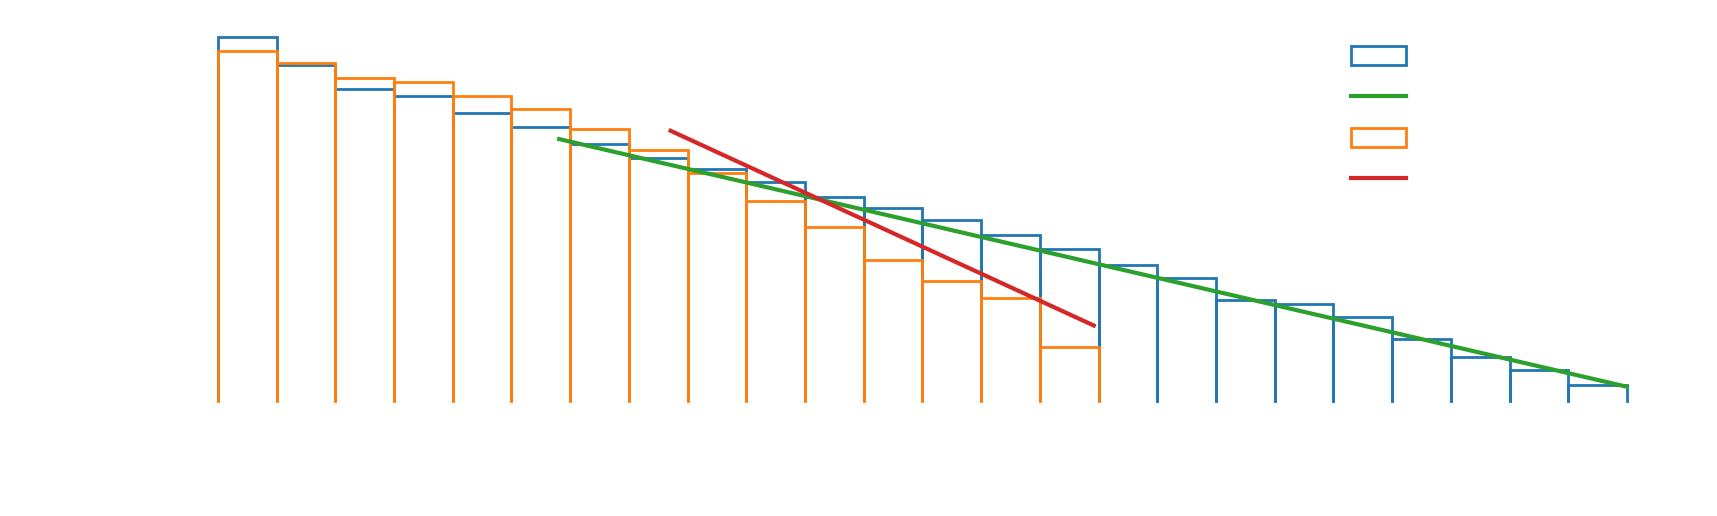

In [63]:
k_out = np.array([k for node, k in G.out_degree()])
k_in = np.array([k for node, k in G.in_degree()])
logbin = np.geomspace(1, max([max(k_out), max(k_in)]), 25)
dense_logbin = np.geomspace(1, logbin[-1], 1000)
with plt.rc_context({
    'text.color': "w",
    'axes.labelcolor': "w",
    'xtick.color': "w",
    'ytick.color': "w",
    }):
    fig, ax = plt.subplots(1, 1, figsize=(10, 2.5))
    ax.patch.set_alpha(0.)
    for spine in ax.spines.values():
        spine.set_edgecolor('w')
    i = 0
    for k, tag, k_max in zip([k_out, k_in],
                             ["Grado Out", "Grado In",],
                             [3e4, 6e2]):
        hist = ax.hist(k, bins=logbin, density=True,
                       fill=False, edgecolor=f"C{i}", label=tag, )
        
        fit = plfit(k)
        k_min = fit._xmin
        gamma = fit._alpha
        gamma_err = fit._alphaerr
        k_sat = fit._ks
        print(tag)
        print(f"k_max = {max(k)}")
        print(f"gamma = ({gamma:.2f} ± {gamma_err:.1g})",
            f"k_min = {k_min}", f"k_sat = {k_sat:.3g}", sep="\n")
        norm = np.sum(hist[1]>k_min)
        # dist = dict(Counter(k))
        # ax.scatter(dist.keys(), np.array(list(dist.values()))/np.sum(hist[1]),
        #            alpha=0.3, edgecolors=f"C{i}")
        y = ((gamma-1)*k_min**(gamma-1)*dense_logbin**(-gamma))/norm
        i += 1
        ax.plot(dense_logbin[(dense_logbin > k_min) & (dense_logbin <= k_max)],
                y[(dense_logbin > k_min) & (dense_logbin <= k_max)],
                c=f"C{i+1}", label=f"Ajuste {tag}")
    print(f"k_mean = {np.mean(k_in):.3g}")
    ax.legend(frameon=False)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Grado")
    ax.set_ylabel("Densidad")
    plt.show()

## Alcance de los nodos

In [4]:
def get_reach(G: nx.Graph, p: float = 1) -> pd.DataFrame:
    """
    Get reach of each node for a given probability 'p'.

    Args:
        G (nx.Graph): Networkx Graph.
        p (float, optional): Probability 'p'. Defaults to 1.

    Returns:
        pd.DataFrame: DataFrame with reach of each node.
    """

    search = ReachFinder(G, p = p)

    # Find reach of each node.
    reach_by_node = search.find_all_nodes()
    reach_by_node = search.remove_self_edges(reach_by_node)

    # Sort libs by reach descending.
    reach_amount = dict(sorted([(k, len(v)) for k, v in reach_by_node.items()], key = lambda x: x[1], reverse=True))
    reach_df = pd.DataFrame([(k, v) for k, v in reach_amount.items()], columns = ["Library", "Reach"]).set_index("Library")

    return reach_df

reach_by_node = get_reach(G, p = 1)

# El 679 fue elegido viendo los valores. La 680 tiene un salto significativo de alcance.
top_reach_libs = list(reach_by_node["Reach"].head(679).index)

Done. Function called 185279 times.


In [6]:
reach_by_node.to_csv("Reach by Node.csv")

## K-Coreness

In [7]:
def delete_by_degree(G: nx.Graph, k = 0, kind="out"):
    G_copy = G.copy()
    if kind == "out":
        degree_dict = G.out_degree()
    elif kind == "in":
        degree_dict = G.in_degree()
    node_degree = dict(sorted(degree_dict, key=lambda x: x[1]))
    k_nodes = [n for n in G_copy.nodes() if node_degree[n] == k]

    if len(k_nodes) != 0:
        G_copy.remove_nodes_from(k_nodes)
    else:
        G_copy = delete_by_degree(G = G_copy, k = k+1)
    return G_copy

def k_coreness(G, kind="out"):
    coreness = {node: 0 for node in G.nodes()}
    G_copy = G.copy()

    i = 1
    
    while G_copy.nodes():

        G_copy = delete_by_degree(G_copy, k = 0, kind=kind)

        prevalent_nodes = G_copy.nodes()
        for node in prevalent_nodes:
            coreness[node] += 1

        i += 1
    
    return coreness

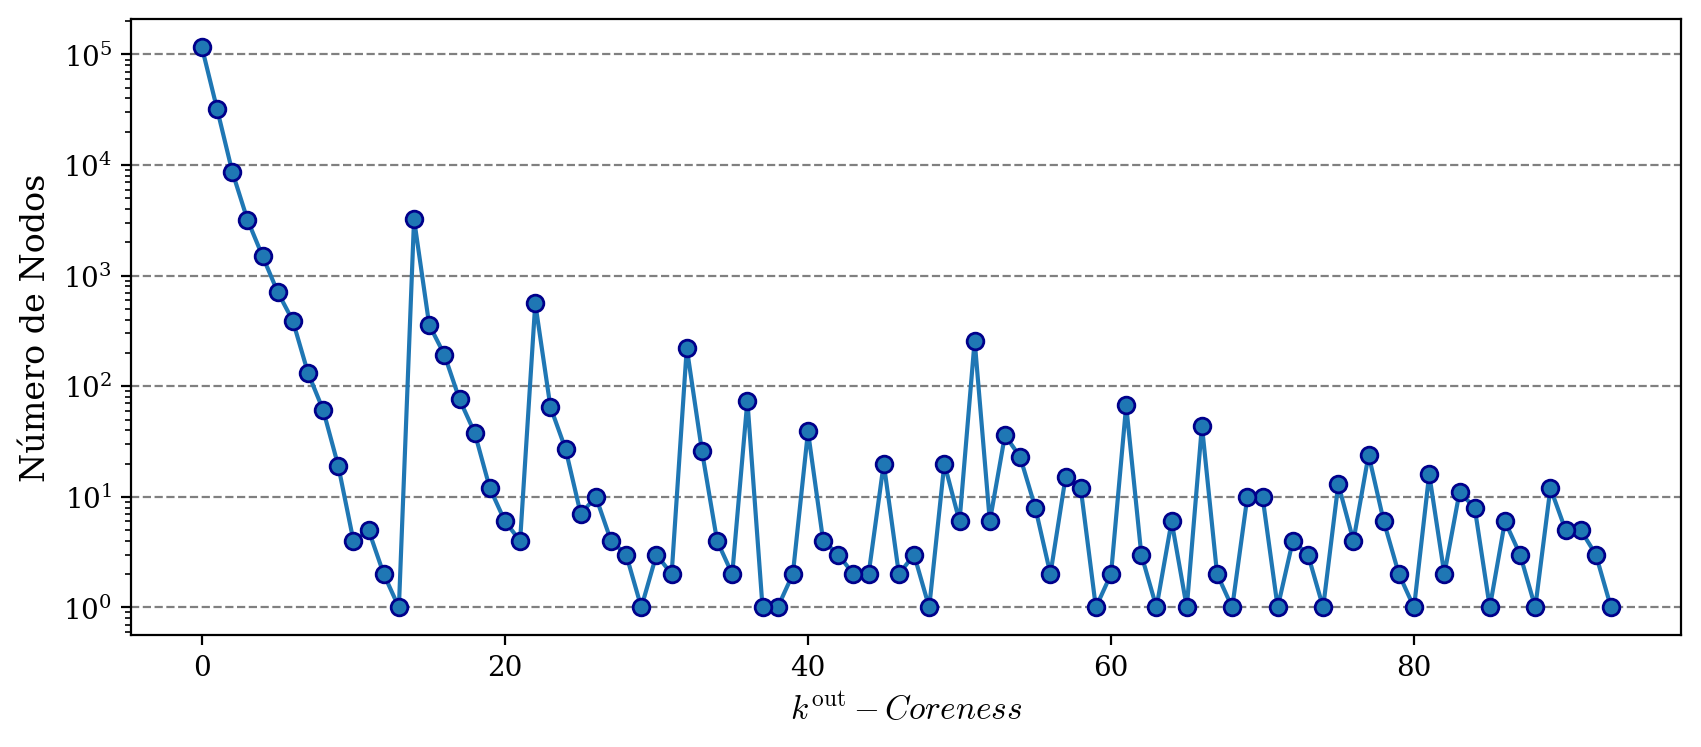

In [8]:
coreness = k_coreness(G, "out")
coreness = dict(sorted(list(coreness.items()), key = lambda x: x[1], reverse=True))
count_coreness = Counter(coreness.values())

with plt.rc_context({
    'text.color': "k",
    'axes.labelcolor': "k",
    'xtick.color': "k",
    'ytick.color': "k",
    }):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.patch.set_alpha(0.)
    for spine in ax.spines.values():
        spine.set_edgecolor("k")

    ax.plot(count_coreness.keys(), count_coreness.values(), 'o-', mec="darkblue", mew=1, zorder=10)
    # ax.hist(coreness.values(), bins=60, fill=False, edgecolor="darkblue", linewidth=1.5, zorder=10)
    ax.set_yscale("log")
    ax.set_xlabel("$k^{\mathrm{out}}-Coreness$")
    ax.set_ylabel("Número de Nodos")
    # ax.set_title("Distribución de\n$K-Coreness$ en la red")
    ax.grid(color="gray", ls="--", axis = "y")
    plt.show()

## Gráficos

In [3]:
comp = sorted(list(nx.connected_components(nx.Graph(G))), key = len, reverse=True)
comp_len = [len(c) for c in comp]
comp_len_counts = dict(Counter(comp_len))

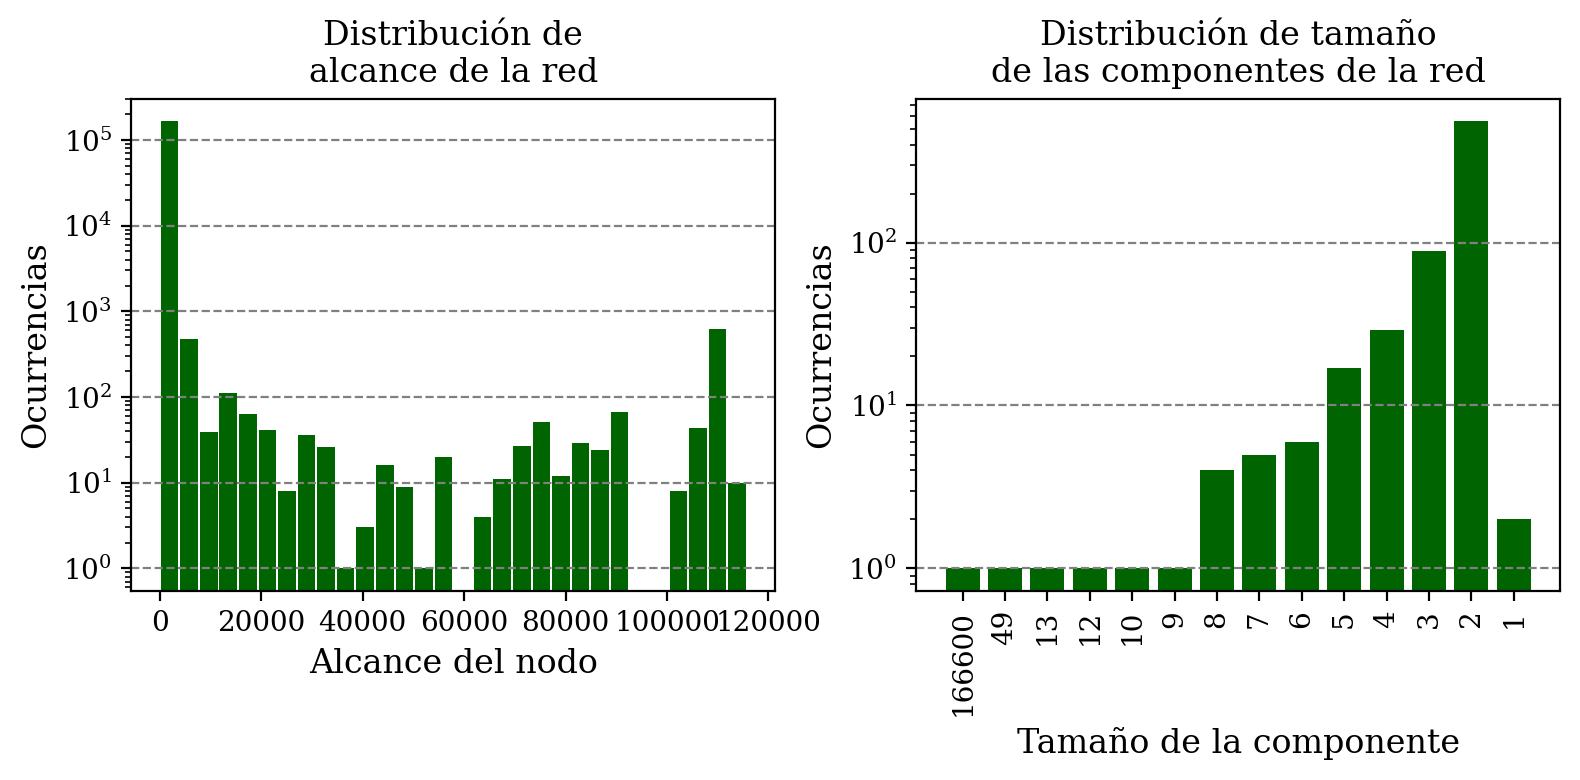

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

# Histograma de alcance de los nodos.
ax[0].hist(reach_by_node["Reach"], bins = 30, rwidth=0.90, color="darkgreen")
ax[0].set_yscale("log")
ax[0].grid(color="gray", ls="--", axis="y")
ax[0].set_xlabel("Alcance del nodo")
ax[0].set_ylabel("Ocurrencias")
ax[0].set_title("Distribución de\nalcance de la red")

# Distribución de componentes en la red.
ax[1].bar(range(len(comp_len_counts)), comp_len_counts.values(), color="darkgreen")
ax[1].set_xticks(range(len(comp_len_counts)))
ax[1].set_xticklabels(comp_len_counts.keys(), rotation = 90)
ax[1].set_yscale("log")
ax[1].grid(color="gray", ls="--", axis="y")
ax[1].set_xlabel("Tamaño de la componente")
ax[1].set_ylabel("Ocurrencias")
ax[1].set_title("Distribución de tamaño\nde las componentes de la red")

plt.show()

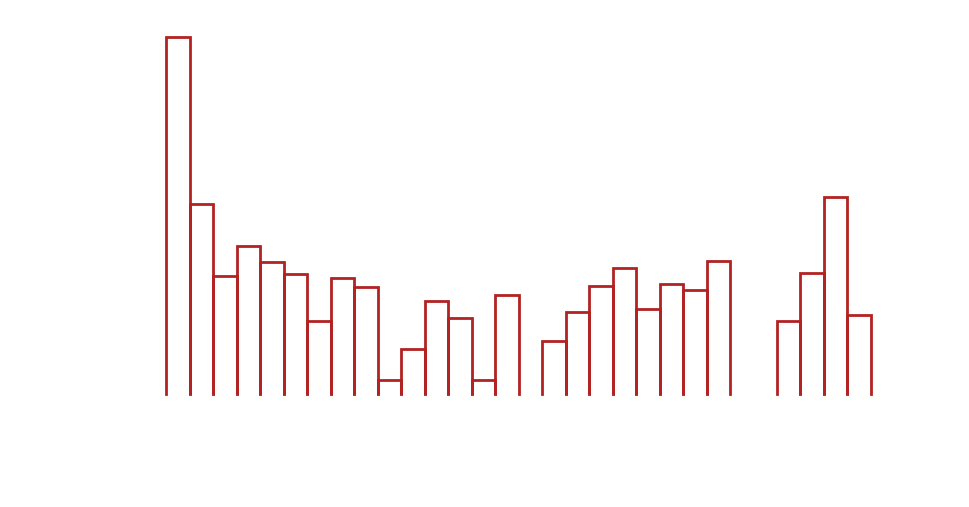

In [14]:
with plt.rc_context({
    'text.color': "w",
    'axes.labelcolor': "w",
    'xtick.color': "w",
    'ytick.color': "w",
    }):
    fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
    ax.patch.set_alpha(0.)
    for spine in ax.spines.values():
        spine.set_edgecolor('w')
    
    # logbin = np.geomspace(1, max(reach_by_node["Reach"]), 30)
    ax.hist(reach_by_node["Reach"], bins=30, fill=False, edgecolor="firebrick")
    ax.set_yscale("log")
    # ax.set_xscale("log")
    ax.set_xlabel("Alcance")
    ax.set_ylabel("Ocurrencias")
    plt.show()

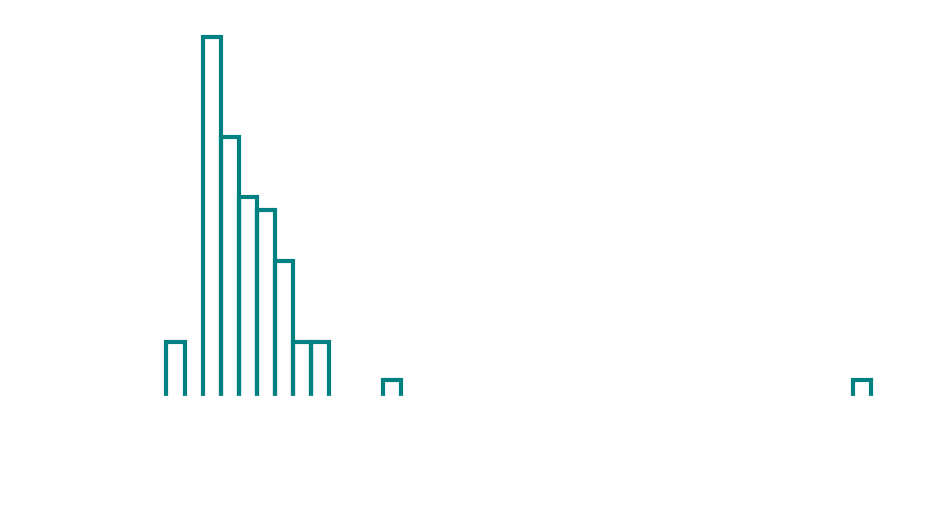

In [24]:
with plt.rc_context({
    'text.color': "w",
    'axes.labelcolor': "w",
    'xtick.color': "w",
    'ytick.color': "w",
    }):
    fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
    ax.patch.set_alpha(0.)
    for spine in ax.spines.values():
        spine.set_edgecolor("w")
    logbin = np.geomspace(1, max(comp_len), 40)
    ax.hist(comp_len, bins=logbin, fill=False, edgecolor="teal", linewidth=1.5)
    # ax.scatter(comp_len_counts.keys(), comp_len_counts.values(), edgecolors="teal", c="teal", alpha=0.5, )
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Tamaño de la Componente")
    ax.set_ylabel("Ocurrencias")
    plt.show()

- La componente 1 es...
- La componente 2 son todos los paquetes de https://github.com/musculoskeletal/gias3.

# Actualización de las librerías mas importantes.

In [ ]:
with open("../../PyPi DataFrame V4.df", "rb") as f:
    df = pickle.load(f)

df.head(5)

,Dependencies,Tags,Licence,Package Version,Python Version,Classifiers,Dependant Libraries Count,Programming Language
0-core-client,[redis],None,Apache 2.0,1.1.0a8,None,[],0.0,None
0-orchestrator,"[jinja2, aioredis, etcd3, netaddr, python-date...",None,Apache 2.0,1.1.0a8,None,[],0.0,None
01d61084-d29e-11e9-96d1-7c5cf84ffe8e,"[click, attrs]",None,None,0.1.0,">=3.7,<4.0","[Programming Language :: Python :: 3, Programm...",2.0,Python
0x-contract-addresses,"[mypy-extensions, bandit, black, coverage, cov...",ethereum cryptocurrency 0x decentralized block...,Apache 2.0,3.0.0,">=3.6, <4","[Development Status :: 5 - Production/Stable, ...",6.0,Python
0x-contract-artifacts,"[mypy-extensions, bandit, black, coverage, cov...",ethereum cryptocurrency 0x decentralized block...,Apache 2.0,3.0.0,">=3.6, <4","[Development Status :: 5 - Production/Stable, ...",4.0,Python


In [4]:
jsons_path = "path/to/jsons"
saved_file = "../../state_files/Releases.json"
filtered_releases_fname = "../../state_files/Filtered Releases.pickle" # Guardo con pickle para tener los datetimes.

# Intentamos cargar el archivo filtrado.
try:
    with open(filtered_releases_fname, "rb") as f:
        filtered_releases = pickle.load(f)

# No encontramos el archivo filtrado. Cargamos el sin filtrar.
except FileNotFoundError:
    # Intentamos cargar el archivo sin filtrar.
    try:
        with open(saved_file, "rb") as f:
            releases_by_package =json.load(f)
    
    # No lo encontramos. Leemos todas las releases.
    except FileNotFoundError:
        filenames = sorted(glob(jsons_path + "/*"))

        releases_by_package = {}
        print("Obteniendo releases de los jsons.")
        for fname in tqdm(filenames):
            with open(fname, "rb") as f:
                project_json = json.load(f)
            
            # Conseguir nombre y listado de versiones.
            if "message" not in project_json.keys():
                package_name = project_json["info"]["name"]
                releases = project_json["releases"]
                package_versions = {}
                
                # Para cada distribución
                for r, info in releases.items():
                    # Si es un listado de sub-versiones (Versiones de Python).
                    if isinstance(info, list): 
                        if info: # Si no está vacia.
                            info = info[0]          
                            # Si tiene guardada la fecha de subida (Por si acaso).  
                            if "upload_time" in info.keys():
                                date = info["upload_time"]
                            else:
                                date = None
                        else:
                            date = None
                    else:
                        date = None
                    
                    package_versions[r] = date
                
                releases_by_package[package_name] = package_versions

        with open(saved_file, "w") as f:
            json.dump(releases_by_package, f)
    
    # Procesamiento extra.
    finally:
        
        print("Eliminando librerias no requeridas.")
        # Filtramos librerias que no quedaron después del procesamiento de Eitu.
        remaining_libs = df.index
        filtered_releases = {k: v for k, v in tqdm(releases_by_package.items()) if k in remaining_libs}

        print("Convirtiendo fechas a datetimes.")
        #Transformo fechas a datetimes para mejor control.
        pypi_date_re = "%Y-%m-%dT%H:%M:%S"
        for lib, releases in tqdm(filtered_releases.items()):
            for r, d in releases.items():
                if d is not None:
                    d = datetime.strptime(d, pypi_date_re)
                filtered_releases[lib][r] = d

        # Finalmente guardamos el procesado con pickle.
        with open(filtered_releases_fname, "wb") as f:
            pickle.dump(filtered_releases, f)


Text(0, 0.5, 'Alcance')

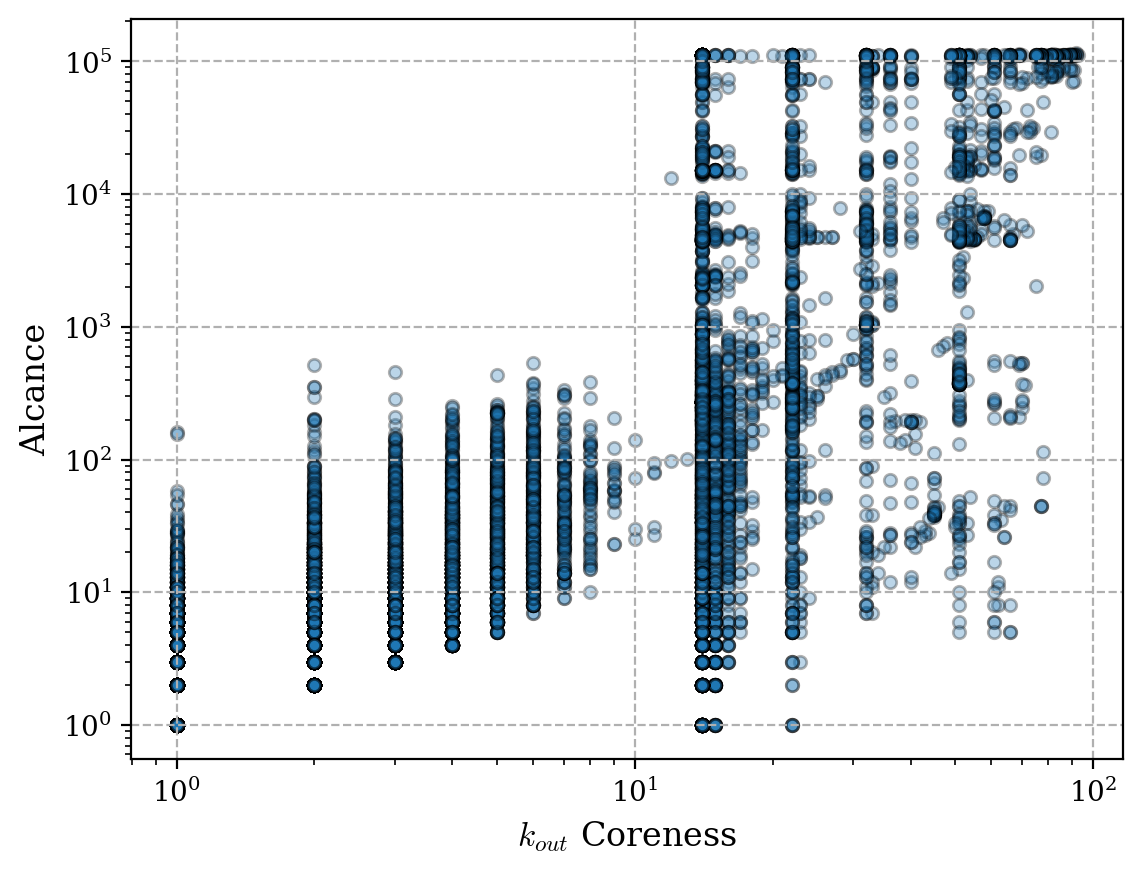

In [10]:
index_map = {v: i for i, v in enumerate(list(coreness.keys()))}

reach_dict = {lib: reach for lib, reach in reach_by_node["Reach"].items()}
reach_dict = dict(sorted(reach_dict.items(), key=lambda pair: index_map[pair[0]]))

plt.scatter(coreness.values(), reach_dict.values(), ec="black", s=20, alpha=0.3)
plt.grid(ls="--")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$k_{out}$ Coreness")
plt.ylabel("Alcance")

In [22]:
filtered_releases_with_date = {k: {r: d for r, d in v.items() if d is not None} for k, v in filtered_releases.items()}

In [39]:
sorted(filtered_releases_with_date["pint-Pandas"].items(), key = lambda x: x[1])

KeyError: 'pint-Pandas'

In [ ]:
with open("../../proc_jsons.json", "rb") as f:
    proc_jsons = json.load(f)

In [48]:
list(filter(lambda x: x["Name"] == "matplotlib", proc_jsons))

[{'Name': 'matplotlib',
  'Dependencies': [],
  'Tags': '',
  'Licence': 'PSF',
  'Package Version': '3.6.1',
  'Python Version': '>=3.8',
  'Classifiers': ['Development Status :: 5 - Production/Stable',
   'Framework :: Matplotlib',
   'Intended Audience :: Education',
   'Intended Audience :: Science/Research',
   'License :: OSI Approved :: Python Software Foundation License',
   'Programming Language :: Python',
   'Programming Language :: Python :: 3',
   'Programming Language :: Python :: 3.10',
   'Programming Language :: Python :: 3.11',
   'Programming Language :: Python :: 3.8',
   'Programming Language :: Python :: 3.9',
   'Topic :: Scientific/Engineering :: Visualization']}]